# Checkpoint to SavedModel

In [1]:
import os, sys

import tensorflow as tf

sys.path.append('..')
from config.train_options import TrainOptions
from GazeGAN import Gaze_GAN2

In [19]:
opt = {
    'nef': 32,
    'n_layers_e': 4,
    'use_sp': True, 
    'is_ss': True, 
    'ngf': 16,
    'n_layers_g': 5,
    'n_layers_d': 5,
    'output_nc': 3,
    'ndf': 16,
    'is_ss': False,
}

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)
opt = Bunch(opt)    

In [20]:
eye_encoder, eye_decoder, generator, discriminator = Gaze_GAN2(opt).build_train_model()
optimizer = tf.keras.optimizers.Adam()

In [21]:
!dir "../gaze_correcter_checkpoints"
checkpoint_path = "../gaze_correcter_checkpoints/ckpt-32"


 Volume in drive G is HDD 4TB
 Volume Serial Number is 0A81-768C

 Directory of G:\Github\GazeCorrection_Fork\gaze_correcter_checkpoints

2021-02-15  08:49    <DIR>          .
2021-02-15  08:49    <DIR>          ..
2021-02-15  08:49               526 checkpoint
2021-02-15  07:53       305ÿ075ÿ152 ckpt-28.data-00000-of-00001
2021-02-15  07:53            24ÿ181 ckpt-28.index
2021-02-15  08:07       305ÿ075ÿ152 ckpt-29.data-00000-of-00001
2021-02-15  08:07            24ÿ181 ckpt-29.index
2021-02-15  08:21       305ÿ075ÿ152 ckpt-30.data-00000-of-00001
2021-02-15  08:21            24ÿ181 ckpt-30.index
2021-02-15  08:35       305ÿ075ÿ152 ckpt-31.data-00000-of-00001
2021-02-15  08:35            24ÿ181 ckpt-31.index
2021-02-15  08:49       305ÿ075ÿ152 ckpt-32.data-00000-of-00001
2021-02-15  08:49            24ÿ181 ckpt-32.index
2021-02-15  01:33         1ÿ479ÿ714 test_samples00.png
2021-02-15  01:47         1ÿ524ÿ948 test_samples01.png
2021-02-15  02:01         1ÿ610ÿ552 test_samples02.png
202

In [22]:
checkpoint = tf.train.Checkpoint(
    eye_encoder=eye_encoder,
    generator=generator,
    discriminator=discriminator,
    optimizer_d=optimizer,
    optimizer_g=optimizer
)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [6]:
save_path = "models/gaze_corrector"
generator._name = 'gaze_corrector'
generator.save(save_path)

INFO:tensorflow:Assets written to: models/gaze_corrector\assets


In [7]:
save_path = "models/eye_encoder"
eye_encoder._name = 'eye_encoder'
eye_encoder.save(save_path)

INFO:tensorflow:Assets written to: models/eye_encoder\assets


# Load SavedModel and Visualize


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1.image import crop_and_resize

from Dataset import Dataset2

In [3]:
# Data preprocessing for mask
def get_Mask_and_pos(eye_pos, flag=0):
    """ Given eye_pos (shape=[4,]), 
        returns masks for cropping eyes. 
    """
    batch_mask = []
    batch_left_eye_pos = []
    batch_right_eye_pos = []
    for i in range(opt.batch_size):

        current_eye_pos = eye_pos[i]
        left_eye_pos = []
        right_eye_pos = []

        if flag == 0:

            mask = np.zeros(shape=[opt.img_size, opt.img_size, opt.output_nc])
            scale = current_eye_pos[1] - 15
            down_scale = current_eye_pos[1] + 15
            l1_1 =int(scale)
            u1_1 =int(down_scale)
            #x
            scale = current_eye_pos[0] - 25
            down_scale = current_eye_pos[0] + 25
            l1_2 = int(scale)
            u1_2 = int(down_scale)

            mask[l1_1:u1_1, l1_2:u1_2, :] = 1.0
            left_eye_pos.append(float(l1_1)/opt.img_size)
            left_eye_pos.append(float(l1_2)/opt.img_size)
            left_eye_pos.append(float(u1_1)/opt.img_size)
            left_eye_pos.append(float(u1_2)/opt.img_size)

            scale = current_eye_pos[3] - 15
            down_scale = current_eye_pos[3] + 15
            l2_1 = int(scale)
            u2_1 = int(down_scale)

            scale = current_eye_pos[2] - 25
            down_scale = current_eye_pos[2] + 25
            l2_2 = int(scale)
            u2_2 = int(down_scale)

            mask[l2_1:u2_1, l2_2:u2_2, :] = 1.0

            right_eye_pos.append(float(l2_1) / opt.img_size)
            right_eye_pos.append(float(l2_2) / opt.img_size)
            right_eye_pos.append(float(u2_1) / opt.img_size)
            right_eye_pos.append(float(u2_2) / opt.img_size)

        batch_mask.append(mask)
        batch_left_eye_pos.append(left_eye_pos)
        batch_right_eye_pos.append(right_eye_pos)

    return np.array(batch_mask), np.array(batch_left_eye_pos), np.array(batch_right_eye_pos)

def crop_resize(input, boxes_left, boxes_right):

    shape = [int(item) for item in input.shape.as_list()]
    return crop_and_resize(input, boxes=boxes_left, box_ind=list(range(0, shape[0])),
                                    crop_size=[int(shape[-3] / 2), int(shape[-2] / 2)]), \
            crop_and_resize(input, boxes=boxes_right, box_ind=list(range(0, shape[0])),
                                crop_size=[int(shape[-3] / 2), int(shape[-2] / 2)])

def inference(x, xm, x_left_p, x_right_p, generator, encoder):
    """Construct training pipeline from x -> y
    """

    # xm - mask where pixel value = 1 where eye region is located
    # xc - full image (pixels in eye region = 0)
    xc = x * (1 - xm)  #corrputed images

    xl_left, xl_right = crop_resize(x, x_left_p, x_right_p)
    
    with tf.device('cpu:0'):
        # Extract eye features
        xl_left_fp  = encoder(xl_left)
        xl_right_fp = encoder(xl_right)

        # Generate gaze-corrected image
        yo = generator([xc, xm, xl_left_fp, xl_right_fp]) 

    return yo, xc + yo*xm

In [5]:
gaze_corrector = tf.keras.models.load_model("../models/gaze_corrector", compile=False)
eye_encoder = tf.keras.models.load_model("../models/eye_encoder", compile=False)

In [6]:
opt = {
    'data_dir': "G:/Dataset/NewGazeData",
    'img_size': 256,
    'capacity': 5000,
    'is_ss': True, 
    'batch_size': 8,
    'num_threads': -1,
    'nef': 32,
    'n_layers_e': 4,
    'use_sp': True, 
    'ngf': 16,
    'n_layers_g': 5,
    'n_layers_d': 5,
    'output_nc': 3,
    'ndf': 16,
    'is_ss': False,
}
class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)
opt = Bunch(opt)    
dataset = Dataset2(opt)
train_dataset, test_dataset = dataset.input()

In [7]:
for x, eye_pos in test_dataset.take(1):
    xm, x_left_p, x_right_p = get_Mask_and_pos(eye_pos)
    y0, y1 = inference(x, xm, x_left_p, x_right_p, gaze_corrector, eye_encoder)

In [8]:
def preprocess_first_image(batch):
    img = batch[0].numpy()
    img = (img + 1) * 127.5
    img = img.astype('uint8')
    return img

In [9]:
img = preprocess_first_image(y1)

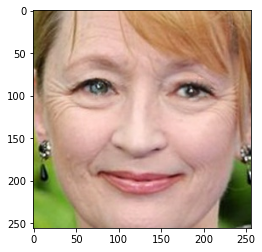

In [10]:
plt.imshow(img)

In [11]:
def visualize(x, y, y_real, save_path, num_samples=10):
    """Given input image x (B,H,W,3) and output image y (B,H,W,3).
    Visualize x, y side by side.
    
    """

    fig, axs = plt.subplots(num_samples,3, figsize=(10,num_samples*5))
    for i in range(num_samples):
        x_temp = ((x+1)/2)[i]
        y_temp = ((y+1)/2)[i]
        y_real_temp = ((y_real+1)/2)[i]

        axs[i][0].imshow(x_temp)
        axs[i][1].imshow(y_temp)
        axs[i][2].imshow(y_real_temp)
    #plt.show()
    fig.savefig(save_path)

def inference(x, xm, x_left_p, x_right_p, generator, encoder):
    """Construct training pipeline from x -> y
    """

    # xm - mask where pixel value = 1 where eye region is located
    # xc - full image (pixels in eye region = 0)
    xc = x * (1 - xm)  #corrputed images

    xl_left, xl_right = crop_resize(x, x_left_p, x_right_p)
    
    with tf.device('cpu:0'):
        # Extract eye features
        xl_left_fp  = encoder(xl_left)
        xl_right_fp = encoder(xl_right)

        # Generate gaze-corrected image
        yo = generator([xc, xm, xl_left_fp, xl_right_fp]) 

    return yo, xc + yo*xm

def visualize_batch(test_dataset, generator, eye_encoder):
    for x, eye_pos in test_dataset.take(1):
        xm, x_left_p, x_right_p = get_Mask_and_pos(eye_pos)
        
        save_path = f"test_samples"
        
        y, y_real = inference(x, xm, x_left_p, x_right_p, generator, eye_encoder)
        visualize(x, y, y_real, save_path, num_samples=7)

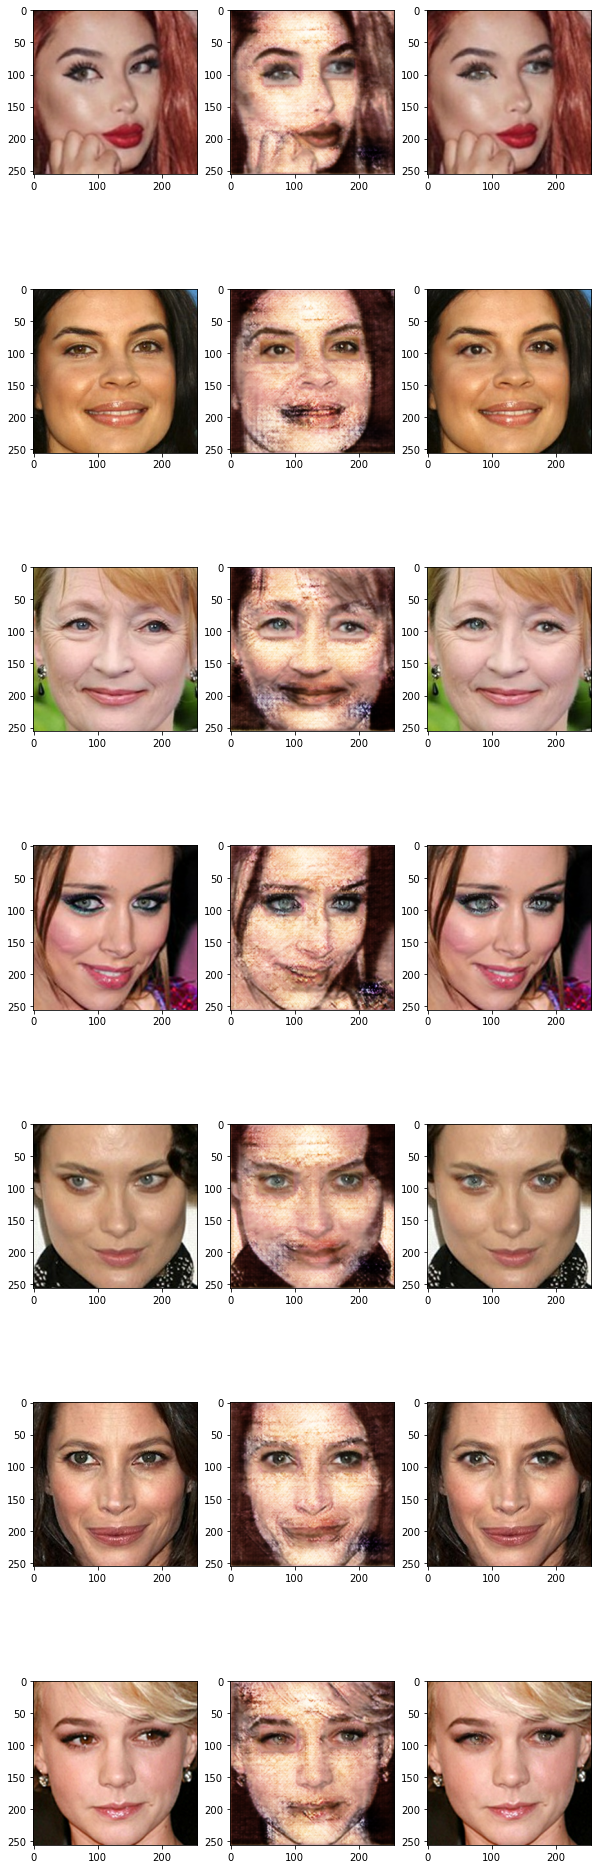

In [13]:
visualize_batch(test_dataset, gaze_corrector, eye_encoder)